# Calculating Terrain Roughness Indices 

There are several commonly used metrics for measuring the roughness, ruggedness, or relative position (valley or ridge) of pixels from a digital elevation model (DEM).  This notebook provides examples of how to easily calculate these from numpy arrays, for inclusion in data processing pipelines.  While these algorithms should be relatively fast sinse they are being calculated using Numpy arrays, they do require the data to be loaded into memory.  Options for extending this methodology to use tiling and processing in parallel using Dask should be doable.



By: Colin Talbert 2018-11-26

#### Import the libraries we'll be using

In [1]:
# import  pandas as pd
import matplotlib.pyplot as plt
import scipy.ndimage as ndi
import numpy as np

import rasterio
from rasterio import plot
# import rasterstats
from rasterio.io import MemoryFile
from owslib.wcs import WebCoverageService



#### First get a chunk of elevation data from the National Map / 3dep WCS services 

In [2]:
bounds = (-122.7600,  47.9000, -122.3500,  48.4000)
plotting_ext =[bounds[0], bounds[2], bounds[1], bounds[3]]

In [3]:
wcs=WebCoverageService('https://elevation.nationalmap.gov:443/arcgis/services/3DEPElevation/ImageServer/WCSServer', version='1.0.0')

# this is the resolution for 1 arc second (30m DEM)
res = 0.00027777777803598

elev=wcs['DEP3ElevationPrototype']

output = wcs.getCoverage(identifier='DEP3ElevationPrototype', bbox=bounds, format='GeoTIFF', resx=res, resy=res, crs=4326)
contents = output.read()

elev = MemoryFile(contents).open()
data = elev.read().squeeze()


#### Let's take a look at the raw elevation data.

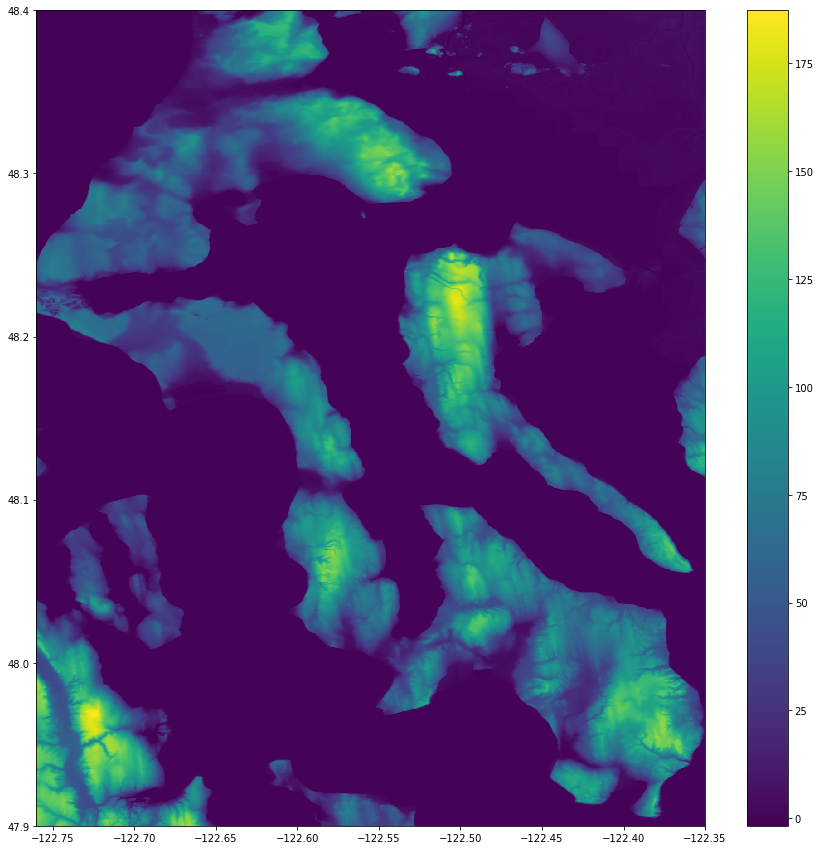

In [4]:
plt.rcParams['figure.figsize'] = [15, 15]

plt.imshow(data, extent=plotting_ext, aspect='equal')
plt.colorbar()
plt.title = ('Zion National Park Elevation')

## Topographic Position Index (Relative topographic position)

as described in: http://gis4geomorphology.com/roughness-topographic-position/

C:\Anaconda3\envs\pyviz\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in true_divide
  
C:\Anaconda3\envs\pyviz\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in true_divide
  


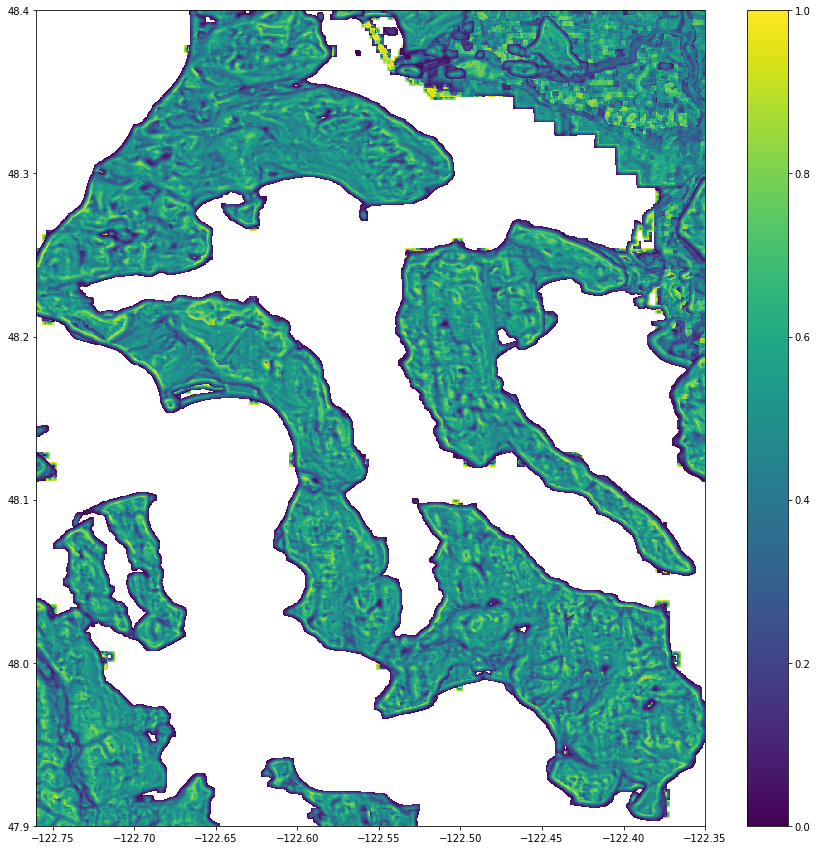

In [5]:
def calc_tpi(data, size=10):
    max_data = ndi.maximum_filter(data, size=size)
    min_data = ndi.minimum_filter(data, size=size)
    mean_data = ndi.uniform_filter(data, size=size)

    tpi = (mean_data-min_data)/(max_data-min_data)
    return tpi
    
    
tpi = calc_tpi(data)
    
plt.imshow(tpi, extent=plotting_ext, aspect='equal')
plt.colorbar()

## Terrain Ruggedness Index (Riley et al. 1999) 
https://download.osgeo.org/qgis/doc/reference-docs/Terrain_Ruggedness_Index.pdf

**Terrain Ruggedness Index (TRI) values**

* LEVEL = 0-80m
* NEARLY LEVEL = 81-116m
* SLIGHTLY RUGGED = 117-161m
* INTERMEDIATELY RUGGED = 162-239m
* MODERATELY RUGGED = 240-497m
* HIGHLY RUGGED = 498-958m
* EXTREMELY RUGGED = 959-4367m

C:\Anaconda3\envs\pyviz\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in sqrt
  """


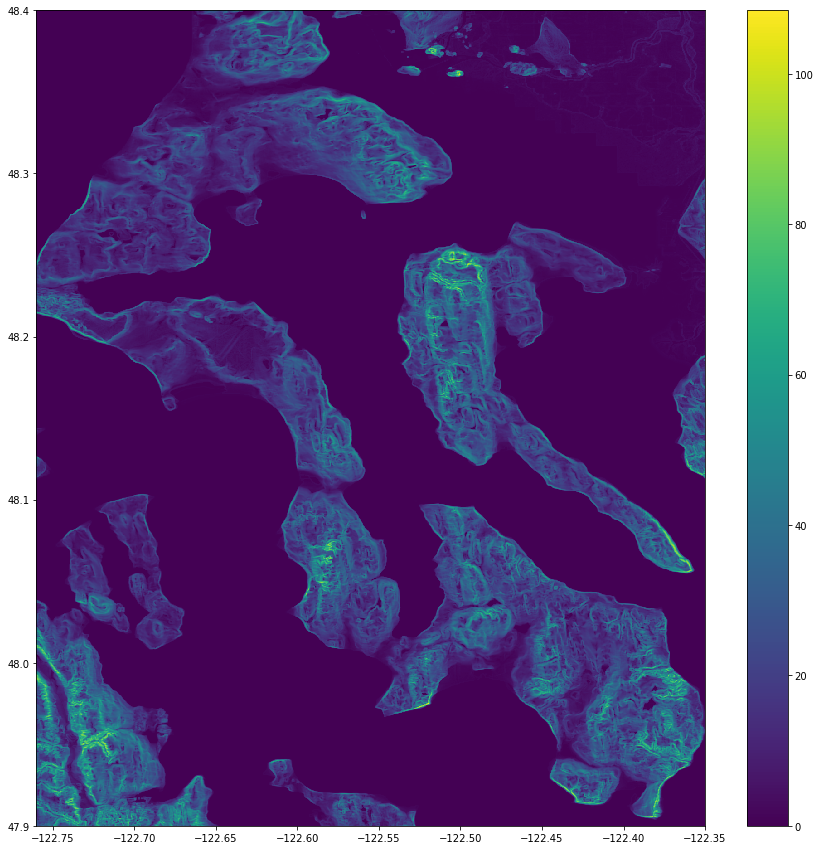

In [10]:
def calc_tri(data, size=3):
    max_data = ndi.maximum_filter(data, size=size)
    min_data = ndi.minimum_filter(data, size=size)

    tri = np.sqrt(np.absolute((np.square(max_data) - np.square(min_data) )))
    return tri

tri = calc_tri(data)
    
plt.imshow(tri, extent=plotting_ext, aspect='equal')
plt.colorbar()